In [8]:
import pandas as pd

df = pd.read_excel(r"C:\Users\heena\OneDrive\Documents\online+retail\Online Retail.xlsx")

print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [12]:
print(df.columns)

df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [14]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

df['CohortIndex'] = (df['InvoiceMonth'] - df['CohortMonth']).apply(lambda x: x.n)

cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().unstack(0)
cohort_data = cohort_data.divide(cohort_data.iloc[0, :], axis=1)
print(cohort_data)

CohortMonth   2010-12   2011-01   2011-02   2011-03   2011-04   2011-05  \
CohortIndex                                                               
0            1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1            0.366102  0.220624  0.186842  0.150442  0.213333  0.190141   
2            0.323164  0.266187  0.186842  0.252212  0.203333  0.172535   
3            0.384181  0.230216  0.284211  0.199115  0.210000  0.172535   
4            0.362712  0.321343  0.271053  0.223451  0.196667  0.207746   
5            0.397740  0.287770  0.247368  0.168142  0.226667  0.232394   
6            0.362712  0.247002  0.252632  0.267699  0.216667  0.264085   
7            0.349153  0.242206  0.278947  0.230088  0.260000  0.095070   
8            0.353672  0.299760  0.247368  0.278761  0.073333       NaN   
9            0.395480  0.326139  0.305263  0.086283       NaN       NaN   
10           0.374011  0.364508  0.068421       NaN       NaN       NaN   
11           0.502825  0.

In [16]:
from datetime import datetime

reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


In [17]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), q=4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1,2,3,4])

rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1).astype(int)
print(rfm.head())

            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Segment  \
CustomerID                                                                     
12346.0         326          1  77183.60       1       1       4         114   
12347.0           2          7   4310.00       4       4       4         444   
12348.0          75          4   1797.24       2       3       4         234   
12349.0          19          1   1757.55       3       1       4         314   
12350.0         310          1    334.40       1       1       2         112   

            RFM_Score  
CustomerID             
12346.0             6  
12347.0            12  
12348.0             9  
12349.0             8  
12350.0             4  


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

x = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Monetary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 2.4518467356979372e-23


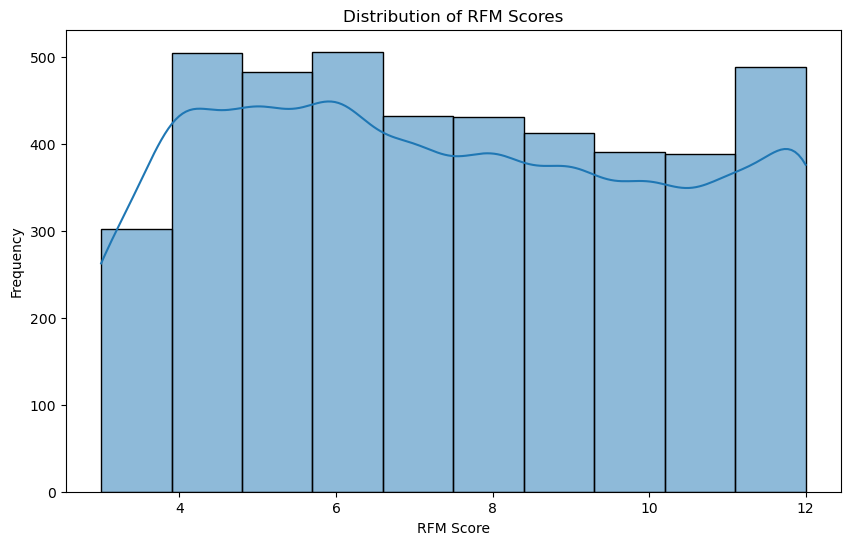

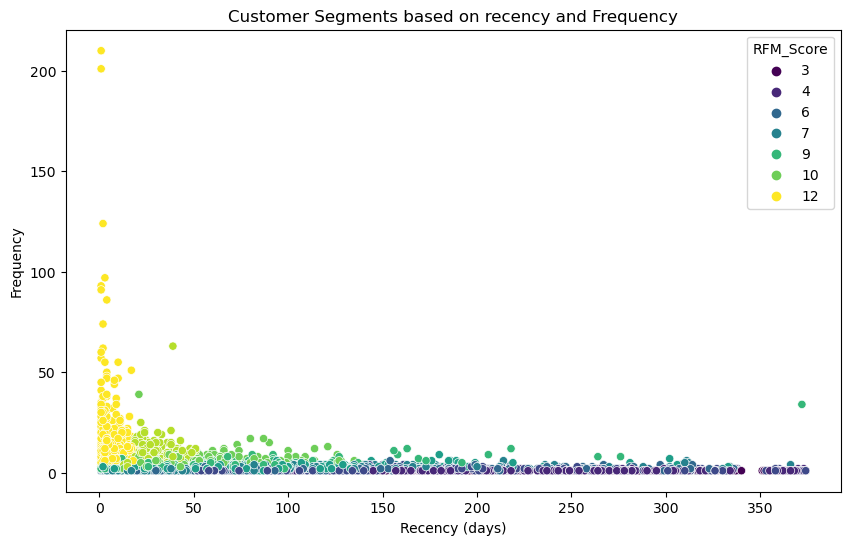

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(rfm['RFM_Score'], bins=10, kde=True)
plt.title("Distribution of RFM Scores")
plt.xlabel("RFM Score")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='RFM_Score', palette='viridis')
plt.title("Customer Segments based on recency and Frequency")
plt.xlabel("Recency (days)")
plt.ylabel("Frequency")
plt.show()